In [367]:
from glob import glob
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import torch
from scipy.stats.mstats import gmean
from scipy.stats import gstd
from pyDOE import lhs
import pandas as pd
from torch import nn 
from torch import optim
from torch.autograd import grad

from burgers1d import sample_domain, sample_dirichlet_boundary, burgers1d_viscous_func

from utilities import get_model


In [359]:
dpm_res_df = pd.read_csv("burgers_dpm_res_halftrange_losses.csv")
transfer_df = pd.read_csv("/Users/richardqiu/Documents/harvard/2022-23/cs229br/project/CS229-Foundations-of-Deep-Learning/pytorch_implementation/transfer_figs/burgers_fullt_burgers_halft/burgers_transfer_burgers_losses.csv")
transfer_half_df = pd.read_csv("transfer_figs/burgers_halft_burgers_halft/burgers_transfer_burgers_losses.csv")
transfer_half00_df = pd.read_csv("transfer_figs/burgers_halft0_burgers_halft/burgers_transfer_burgers_losses.csv")
transfer_half01_df = pd.read_csv("transfer_figs/burgers_halft0.1_burgers_halft/burgers_transfer_burgers_losses.csv")
transfer_half02_df = pd.read_csv("transfer_figs/burgers_halft0.2_burgers_halft/burgers_transfer_burgers_losses.csv")
transfer_half03_df = pd.read_csv("transfer_figs/burgers_halft0.3_burgers_halft/burgers_transfer_burgers_losses.csv")
transfer_half04_df = pd.read_csv("transfer_figs/burgers_halft0.4_burgers_halft/burgers_transfer_burgers_losses.csv")
transfer_half05_df = pd.read_csv("transfer_figs/burgers_halft0.5_burgers_halft/burgers_transfer_burgers_losses.csv")
transfer_half0105_df = pd.read_csv("transfer_figs/burgers_halft0.1-0.5_burgers_halft/burgers_transfer_burgers_losses.csv")
no_dpm_res_df = pd.read_csv("burgers_res_halftrange_losses.csv")
dpm_df = pd.read_csv("burgers_dpm_stdarch_halftrange_losses.csv")
no_dpm_df = pd.read_csv("burgers_stdarch_halftrange/burgers_stdarch_halftrange_losses.csv")

dpm_df["dpm"] = "dpm, 5x100"
no_dpm_df["dpm"] = "no dpm, 5x100"
dpm_res_df["dpm"] = "dpm, 8x20 res"
transfer_df["dpm"] = "transfer full 5x100"
transfer_half_df["dpm"] = "transfer half [0, 0.5] 5x100"
transfer_half00_df["dpm"] = "transfer half [0, 0.5] (2) 5x100"
transfer_half01_df["dpm"] = "transfer half [0.1, 0.6] 5x100"
transfer_half02_df["dpm"] = "transfer half [0.2, 0.7] 5x100"
transfer_half03_df["dpm"] = "transfer half [0.3, 0.8] 5x100"
transfer_half04_df["dpm"] = "transfer half [0.4, 0.9] 5x100"
transfer_half05_df["dpm"] = "transfer half [0.5, 1.0] 5x100"
transfer_half0105_df["dpm"] = "transfer half [0.1, 0.5] 5x100"
no_dpm_res_df["dpm"] = "no dpm, 8x20 res"
df = pd.concat(
    [
        dpm_df,
        no_dpm_df,
        dpm_res_df,
        no_dpm_res_df,
        transfer_df,
        transfer_half_df,
        transfer_half00_df,
        transfer_half01_df,
        transfer_half02_df,
        transfer_half03_df,
        transfer_half04_df,
        transfer_half05_df,
        transfer_half0105_df,
    ], ignore_index=True)
print(df.columns)

Index(['interp_domain_loss', 'interp_boundary_loss', 'interp_comb_loss',
       'extrap_domain_loss', 'extrap_boundary_loss', 'extrap_comb_loss',
       'grad1', 'grad2', 'grad3', 'dpm'],
      dtype='object')


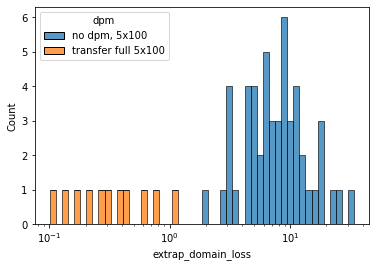

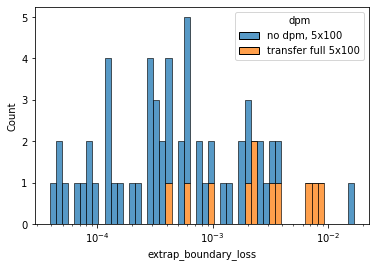

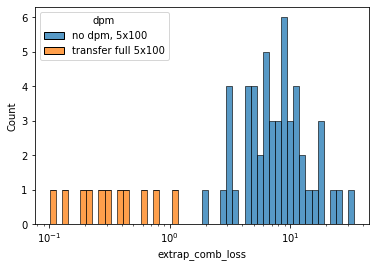

In [246]:
mask = df["dpm"].isin(["transfer half 5x100", "transfer full 5x100", "no dpm, 5x100"])
for extrap_loss in ["extrap_domain_loss", "extrap_boundary_loss", "extrap_comb_loss"]:
    plt.figure()
    sns.histplot(
        data=df[mask],
        x=extrap_loss,
        multiple="stack",
        hue="dpm",
        bins=50,
        log_scale=True,
    )
    plt.show()


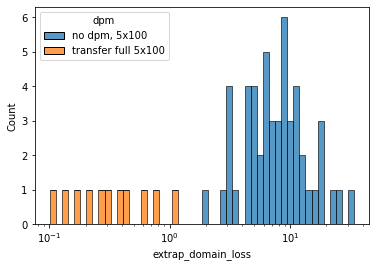

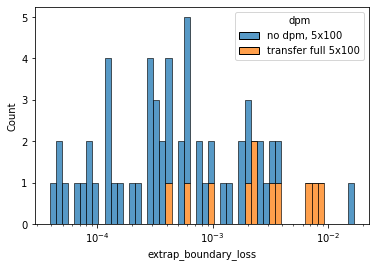

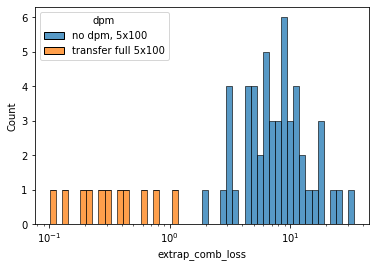

In [247]:
mask = df["dpm"].isin(["transfer half 5x100", "transfer full 5x100", "no dpm, 5x100"])
for extrap_loss in ["extrap_domain_loss", "extrap_boundary_loss", "extrap_comb_loss"]:
    plt.figure()
    sns.histplot(
        data=df[mask],
        x=extrap_loss,
        multiple="stack",
        hue="dpm",
        bins=50,
        log_scale=True,
    )
    plt.show()


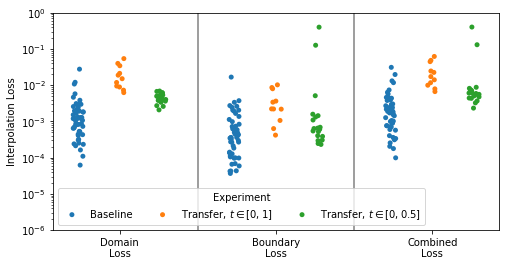

In [249]:
df["id"] = df.index
df_long = pd.wide_to_long(df, stubnames="interp_", i="id", j="loss", suffix=r'\w+').reset_index().drop("id", axis=1)
mask = df_long["dpm"].isin(["transfer half [0, 0.5] 5x100", "transfer full 5x100", "no dpm, 5x100"])

plt.figure(figsize=[8, 4])
sns.stripplot(
    data=df_long[mask],
    x="loss",
    y="interp_",
    hue="dpm",
    dodge=True,
)
for x in range(0, 2):
  plt.plot([x + 0.5, x + 0.5], [0, 10000], c='grey')
plt.yscale("log")
plt.ylim(1e-6, 1e0)
plt.ylabel("Interpolation Loss")
plt.xlabel("")
plt.xticks([0, 1, 2], ["Domain\nLoss", "Boundary\nLoss", "Combined\nLoss"])
plt.legend(title='Experiment', labels=["Baseline", r"Transfer, $t \in [0, 1]$", r"Transfer, $t \in [0, 0.5]$"], ncol=3)
plt.savefig("transfer_interpolation_losses.pdf")
plt.show()

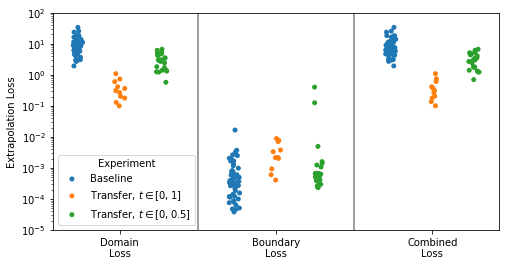

In [252]:
df["id"] = df.index
df_long = pd.wide_to_long(df, stubnames="extrap_", i="id", j="loss", suffix=r'\w+').reset_index().drop("id", axis=1)
mask = df_long["dpm"].isin(["transfer half [0, 0.5] 5x100", "transfer full 5x100", "no dpm, 5x100"])

plt.figure(figsize=[8, 4])
sns.stripplot(
    data=df_long[mask],
    x="loss",
    y="extrap_",
    hue="dpm",
    dodge=True,
)
for x in range(0, 2):
  plt.plot([x + 0.5, x + 0.5], [0, 10000], c='grey')
plt.yscale("log")
plt.ylim(1e-5, 1e2)
plt.ylabel("Extrapolation Loss")
plt.xlabel("")
plt.xticks([0, 1, 2], ["Domain\nLoss", "Boundary\nLoss", "Combined\nLoss"])
plt.legend(title='Experiment', labels=["Baseline", r"Transfer, $t \in [0, 1]$", r"Transfer, $t \in [0, 0.5]$"])
plt.savefig("transfer_extrapolation_losses.pdf")
plt.show()

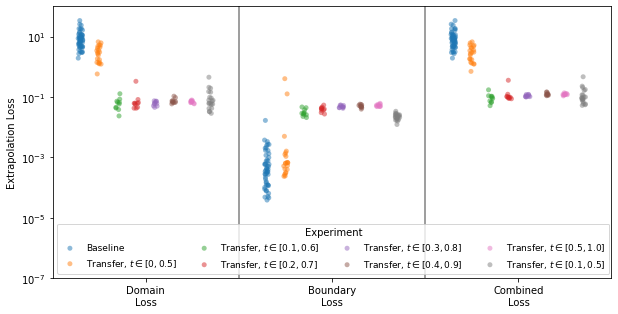

In [283]:
df["id"] = df.index
df_long = pd.wide_to_long(df, stubnames="extrap_", i="id", j="loss", suffix=r'\w+').reset_index().drop("id", axis=1)
mask = df_long["dpm"].isin(
    [
        "transfer half [0, 0.5] 5x100",
        # "transfer half [0, 0.5] (2) 5x100",
        "transfer half [0.1, 0.6] 5x100",
        "transfer half [0.2, 0.7] 5x100",
        "transfer half [0.3, 0.8] 5x100",
        "transfer half [0.4, 0.9] 5x100",
        "transfer half [0.5, 1.0] 5x100",
        "transfer half [0.1, 0.5] 5x100",
        "no dpm, 5x100",
    ]
)

plt.figure(figsize=[10, 5])
sns.stripplot(
    data=df_long[mask],
    x="loss",
    y="extrap_",
    hue="dpm",
    dodge=True,
    alpha=0.5,
)
for x in range(0, 2):
  plt.plot([x + 0.5, x + 0.5], [0, 10000], c='grey')
plt.yscale("log")
plt.ylim(1e-7, 1e2)
plt.ylabel("Extrapolation Loss")
plt.xlabel("")
plt.xticks([0, 1, 2], ["Domain\nLoss", "Boundary\nLoss", "Combined\nLoss"])
plt.legend(
    title='Experiment', 
    labels=[
        "Baseline",
        r"Transfer, $t \in [0, 0.5]$",
        r"Transfer, $t \in [0.1, 0.6]$",
        r"Transfer, $t \in [0.2, 0.7]$",
        r"Transfer, $t \in [0.3, 0.8]$",
        r"Transfer, $t \in [0.4, 0.9]$",
        r"Transfer, $t \in [0.5, 1.0]$",
        r"Transfer, $t \in [0.1, 0.5]$",
    ],
    fontsize=9,
    ncols=4,
)
plt.savefig("transfer_extrapolation_losses_halftranges.pdf")
plt.show()

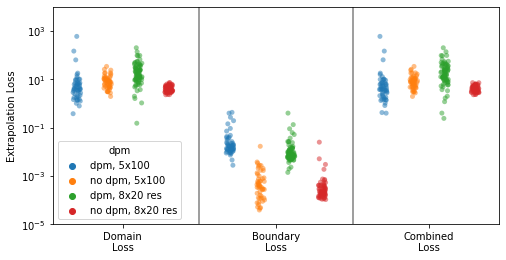

In [239]:
df["id"] = df.index
df_long = pd.wide_to_long(df, stubnames="extrap_", i="id", j="loss", suffix=r'\w+').reset_index().drop("id", axis=1)
mask = df_long["dpm"].isin(["no dpm, 8x20 res", "dpm, 8x20 res", "no dpm, 5x100", "dpm, 5x100"])

plt.figure(figsize=[8, 4])
sns.stripplot(
    data=df_long[mask],
    x="loss",
    y="extrap_",
    hue="dpm",
    dodge=True,
    alpha=0.5,
)
for x in range(0, 2):
  plt.plot([x + 0.5, x + 0.5], [0, 10000], c='grey')
plt.yscale("log")
plt.ylim(1e-5, 1e4)
plt.ylabel("Extrapolation Loss")
plt.xlabel("")
plt.xticks([0, 1, 2], ["Domain\nLoss", "Boundary\nLoss", "Combined\nLoss"])
# plt.legend(title='Experiment', labels=["DPM", "Baseline"], loc="lower left")
# plt.savefig("dpm_8x20_extrapolation.pdf")
plt.show()

In [ ]:
df["id"] = df.index
df_long = pd.wide_to_long(df, stubnames="extrap_", i="id", j="loss", suffix=r'\w+').reset_index().drop("id", axis=1)
mask = df_long["dpm"].isin(["no dpm, 5x100", "dpm, 8x20 res"])

plt.figure(figsize=[8, 4])
sns.stripplot(
    data=df_long[mask],
    x="loss",
    y="extrap_",
    hue="dpm",
    dodge=True,
)
for x in range(0, 2):
  plt.plot([x + 0.5, x + 0.5], [0, 10000], c='grey')
plt.yscale("log")
plt.ylim(1e-5, 1e3)
plt.ylabel("Extrapolation Loss")
plt.xlabel("")
plt.xticks([0, 1, 2], ["Domain\nLoss", "Boundary\nLoss", "Combined\nLoss"])
# plt.legend(title='Experiment', labels=["DPM", "Baseline"], loc="lower left")
plt.savefig("dpm_8x20_extrapolation.pdf")
plt.show()

In [218]:
baseline = df[df["dpm"]=="no dpm, 5x100"]["extrap_comb_loss"]
transfer_full = df[df["dpm"]=="transfer full 5x100"]["extrap_comb_loss"]
transfer_half = df[df["dpm"]=="transfer half 5x100"]["extrap_comb_loss"]
print("baseline: ", gmean(baseline), gstd(baseline))
print("transfer full: ", gmean(transfer_full), gstd(transfer_full))
print("transfer half: ", gmean(transfer_half), gstd(transfer_half))
print()
print("baseline: ", np.mean(baseline), np.std(baseline))
print("transfer full: ", np.mean(transfer_full), np.std(transfer_full))
print("transfer half: ", np.mean(transfer_half), np.std(transfer_half))

baseline:  7.623764339143216 1.848797300074476
transfer full:  0.3186676557164592 2.0713624763012155
transfer half:  2.68593092650658 2.0776493248841126

baseline:  9.212405475915647 6.240356079738234
transfer full:  0.404479404064742 0.2876882298497175
transfer half:  3.32105153799057 1.9706919193198422


## L2 Errors

(20301, 3)


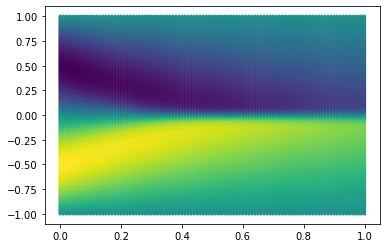

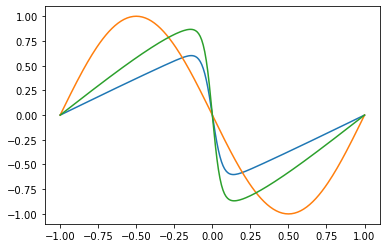

In [320]:
numerical_sol = np.loadtxt("viscous_burgers1d_nu075_numericalsoln.csv", delimiter=",")
print(numerical_sol.shape)
plt.scatter(numerical_sol[:, 0], numerical_sol[:, 1], c=numerical_sol[:, 2], s=5, alpha=1)
plt.show()
plt.plot(numerical_sol[-201:, 1], numerical_sol[-201:, 2])
plt.plot(numerical_sol[:201, 1], numerical_sol[:201, 2])
n=50
plt.plot(numerical_sol[201*n:201*(n+1), 1], numerical_sol[201*n:201*(n+1), 2])
plt.show()

In [348]:
extrap_mask = (numerical_sol[:, 0] > 0.5)

l2_error = torch.nn.MSELoss()
model = get_model(2, 3)
model.load_state_dict(torch.load("transfer_figs/burgers_halft0_burgers_halft/model_weights_10.pth"))
val_input = torch.tensor(numerical_sol[extrap_mask][:, :2], dtype=torch.float32)
val_output = torch.tensor(numerical_sol[extrap_mask][:, 2], dtype=torch.float32)
model_out = model(val_input)[:, 0].detach().cpu()
model_out.shape

torch.Size([10050])

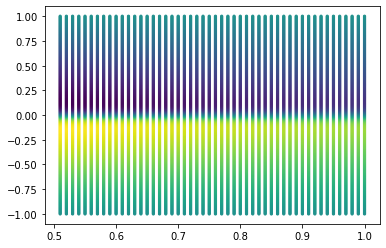

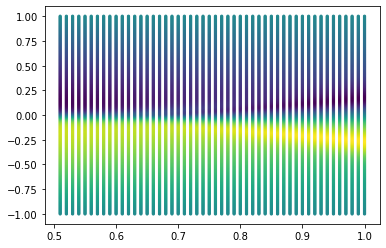

0.005436593666672707


In [351]:
plt.scatter(val_input[:, 0], val_input[:, 1], c=val_output, s=5, alpha=1)
plt.show()
plt.scatter(val_input[:, 0], val_input[:, 1], c=model_out, s=5, alpha=1)
plt.show()

print(l2_error(val_output, model_out).item())    

In [375]:
interp_mask = (numerical_sol[:, 0] < 0.5)
extrap_mask = (numerical_sol[:, 0] > 0.5)

val_interp_input = torch.tensor(numerical_sol[interp_mask][:, :2], dtype=torch.float32)
val_interp_output = torch.tensor(numerical_sol[interp_mask][:, 2], dtype=torch.float32)
val_extrap_input = torch.tensor(numerical_sol[extrap_mask][:, :2], dtype=torch.float32)
val_extrap_output = torch.tensor(numerical_sol[extrap_mask][:, 2], dtype=torch.float32)

experiments = [
    "transfer_figs/burgers_halft0_burgers_halft/burgers_transfer_burgers_losses.csv",
    "transfer_figs/burgers_halft0.1_burgers_halft/burgers_transfer_burgers_losses.csv",
    "transfer_figs/burgers_halft0.2_burgers_halft/burgers_transfer_burgers_losses.csv",
    "transfer_figs/burgers_halft0.3_burgers_halft/burgers_transfer_burgers_losses.csv",
    "transfer_figs/burgers_halft0.4_burgers_halft/burgers_transfer_burgers_losses.csv",
    "transfer_figs/burgers_halft0.5_burgers_halft/burgers_transfer_burgers_losses.csv",
    "transfer_figs/burgers_halft0.1-0.5_burgers_halft/burgers_transfer_burgers_losses.csv",
    "burgers_stdarch_halftrange/burgers_stdarch_halftrange_losses.csv",
]

for experiment in experiments:
    print(experiment)
    experiment_dir = os.path.dirname(experiment)
    model_paths = sorted(glob(f"{experiment_dir}/*.pth"))
    interp_l2_errors = []
    extrap_l2_errors = []
    for model_path in model_paths:
        l2_error = torch.nn.MSELoss()
        if "stdarch" in experiment: 
            model = get_model(2, 1)
        else: 
            model = get_model(2, 3)
        model.load_state_dict(torch.load(model_path))
        model_interp_out = model(val_interp_input)[:, 0].detach().cpu()
        model_extrap_out = model(val_extrap_input)[:, 0].detach().cpu()
        interp_l2_errors.append(l2_error(val_output, model_interp_out).item())
        extrap_l2_errors.append(l2_error(val_output, model_extrap_out).item())

    df = pd.read_csv(experiment)[-len(l2_errors):]
    df["extrap_l2"] = l2_errors
    df.to_csv(f"{experiment[:-4]}_l2.csv")

transfer_figs/burgers_halft0_burgers_halft/burgers_transfer_burgers_losses.csv
transfer_figs/burgers_halft0.1_burgers_halft/burgers_transfer_burgers_losses.csv
transfer_figs/burgers_halft0.2_burgers_halft/burgers_transfer_burgers_losses.csv
transfer_figs/burgers_halft0.3_burgers_halft/burgers_transfer_burgers_losses.csv
transfer_figs/burgers_halft0.4_burgers_halft/burgers_transfer_burgers_losses.csv
transfer_figs/burgers_halft0.5_burgers_halft/burgers_transfer_burgers_losses.csv
transfer_figs/burgers_halft0.1-0.5_burgers_halft/burgers_transfer_burgers_losses.csv
burgers_stdarch_halftrange/burgers_stdarch_halftrange_losses.csv


In [377]:
transfer_half00_df = pd.read_csv("transfer_figs/burgers_halft0_burgers_halft/burgers_transfer_burgers_losses_l2.csv")
transfer_half01_df = pd.read_csv("transfer_figs/burgers_halft0.1_burgers_halft/burgers_transfer_burgers_losses_l2.csv")
transfer_half02_df = pd.read_csv("transfer_figs/burgers_halft0.2_burgers_halft/burgers_transfer_burgers_losses_l2.csv")
transfer_half03_df = pd.read_csv("transfer_figs/burgers_halft0.3_burgers_halft/burgers_transfer_burgers_losses_l2.csv")
transfer_half04_df = pd.read_csv("transfer_figs/burgers_halft0.4_burgers_halft/burgers_transfer_burgers_losses_l2.csv")
transfer_half05_df = pd.read_csv("transfer_figs/burgers_halft0.5_burgers_halft/burgers_transfer_burgers_losses_l2.csv")
transfer_half0105_df = pd.read_csv("transfer_figs/burgers_halft0.1-0.5_burgers_halft/burgers_transfer_burgers_losses_l2.csv")
no_dpm_df = pd.read_csv("burgers_stdarch_halftrange/burgers_stdarch_halftrange_losses_l2.csv")

transfer_half00_df["dpm"] = "transfer half [0, 0.5] 5x100"
transfer_half01_df["dpm"] = "transfer half [0.1, 0.6] 5x100"
transfer_half02_df["dpm"] = "transfer half [0.2, 0.7] 5x100"
transfer_half03_df["dpm"] = "transfer half [0.3, 0.8] 5x100"
transfer_half04_df["dpm"] = "transfer half [0.4, 0.9] 5x100"
transfer_half05_df["dpm"] = "transfer half [0.5, 1.0] 5x100"
transfer_half0105_df["dpm"] = "transfer half [0.1, 0.5] 5x100"
no_dpm_df["dpm"] = "no dpm, 5x100"
df = pd.concat(
    [
        no_dpm_df,
        transfer_half00_df,
        transfer_half01_df,
        transfer_half02_df,
        transfer_half03_df,
        transfer_half04_df,
        transfer_half05_df,
        transfer_half0105_df,
    ], ignore_index=True)
print(df.columns)

Index(['Unnamed: 0', 'interp_domain_loss', 'interp_boundary_loss',
       'interp_comb_loss', 'extrap_domain_loss', 'extrap_boundary_loss',
       'extrap_comb_loss', 'grad1', 'grad2', 'grad3', 'extrap_l2', 'dpm'],
      dtype='object')


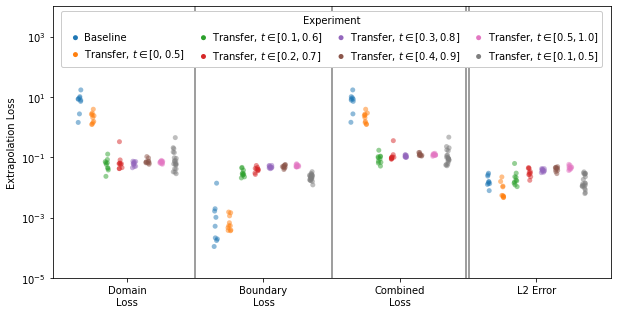

In [403]:
df["id"] = df.index
df_long = pd.wide_to_long(df, stubnames="extrap_", i="id", j="loss", suffix=r'\w+').reset_index().drop("id", axis=1)
mask = df_long["dpm"].isin(
    [
        "transfer half [0, 0.5] 5x100",
        "transfer half [0.1, 0.6] 5x100",
        "transfer half [0.2, 0.7] 5x100",
        "transfer half [0.3, 0.8] 5x100",
        "transfer half [0.4, 0.9] 5x100",
        "transfer half [0.5, 1.0] 5x100",
        "transfer half [0.1, 0.5] 5x100",
        "no dpm, 5x100",
    ]
)

plt.figure(figsize=[10, 5])
sns.stripplot(
    data=df_long[mask],
    x="loss",
    y="extrap_",
    hue="dpm",
    dodge=True,
    alpha=0.5,
)
for x in range(0, 2):
  plt.plot([x + 0.5, x + 0.5], [0, 10000], c='grey')
plt.plot([2.489, 2.489], [0, 10000], c='grey')
plt.plot([2.511, 2.511], [0, 10000], c='grey')
plt.yscale("log")
plt.ylim(1e-5, 1e4)
plt.ylabel("Extrapolation Loss")
plt.xlabel("")
plt.xticks([0, 1, 2, 3], ["Domain\nLoss", "Boundary\nLoss", "Combined\nLoss", "L2 Error"])
legend = plt.legend(
    title='Experiment', 
    labels=[
        "Baseline",
        r"Transfer, $t \in [0, 0.5]$",
        r"Transfer, $t \in [0.1, 0.6]$",
        r"Transfer, $t \in [0.2, 0.7]$",
        r"Transfer, $t \in [0.3, 0.8]$",
        r"Transfer, $t \in [0.4, 0.9]$",
        r"Transfer, $t \in [0.5, 1.0]$",
        r"Transfer, $t \in [0.1, 0.5]$",
    ],
    fontsize=10,
    ncols=4,
    columnspacing=0.8,
    framealpha=1,
    handletextpad=-0.1,
    loc="upper center",
)
for handle in legend.legend_handles: 
    handle.set_alpha(1)
plt.savefig("transfer_extrapolation_losses_halftranges_l2.pdf")
plt.show()

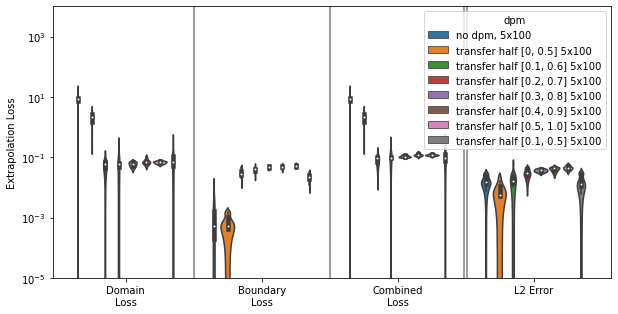

In [405]:
df["id"] = df.index
df_long = pd.wide_to_long(df, stubnames="extrap_", i="id", j="loss", suffix=r'\w+').reset_index().drop("id", axis=1)
mask = df_long["dpm"].isin(
    [
        "transfer half [0, 0.5] 5x100",
        "transfer half [0.1, 0.6] 5x100",
        "transfer half [0.2, 0.7] 5x100",
        "transfer half [0.3, 0.8] 5x100",
        "transfer half [0.4, 0.9] 5x100",
        "transfer half [0.5, 1.0] 5x100",
        "transfer half [0.1, 0.5] 5x100",
        "no dpm, 5x100",
    ]
)

plt.figure(figsize=[10, 5])
sns.violinplot(
    data=df_long[mask],
    x="loss",
    y="extrap_",
    hue="dpm",
    dodge=True,
    alpha=0.5,
)
for x in range(0, 2):
  plt.plot([x + 0.5, x + 0.5], [0, 10000], c='grey')
plt.plot([2.489, 2.489], [0, 10000], c='grey')
plt.plot([2.511, 2.511], [0, 10000], c='grey')
plt.yscale("log")
plt.ylim(1e-5, 1e4)
plt.ylabel("Extrapolation Loss")
plt.xlabel("")
plt.xticks([0, 1, 2, 3], ["Domain\nLoss", "Boundary\nLoss", "Combined\nLoss", "L2 Error"])
# legend = plt.legend(
#     title='Experiment', 
#     labels=[
#         "Baseline",
#         r"Transfer, $t \in [0, 0.5]$",
#         r"Transfer, $t \in [0.1, 0.6]$",
#         r"Transfer, $t \in [0.2, 0.7]$",
#         r"Transfer, $t \in [0.3, 0.8]$",
#         r"Transfer, $t \in [0.4, 0.9]$",
#         r"Transfer, $t \in [0.5, 1.0]$",
#         r"Transfer, $t \in [0.1, 0.5]$",
#     ],
#     fontsize=10,
#     ncols=4,
#     columnspacing=0.8,
#     framealpha=1,
#     handletextpad=-0.1,
#     loc="upper center",
# )
for handle in legend.legend_handles: 
    handle.set_alpha(1)
# plt.savefig("transfer_extrapolation_losses_halftranges_l2.pdf")
plt.show()

In [2]:
N_u = 100
N_f  = 10000

data = scipy.io.loadmat("../../DPM/Data/burgers_shock.mat")

t = data['t'].flatten()[:, None]
x = data['x'].flatten()[:, None]
Exact = np.real(data['usol']).T

len1 = len(t[t <= 0.5]) 
len2 = len(t[t <= 0.8])
t_train = t[0: len1, :]
t_val = t[len1:len2, :] 
t_test = t[len2:, :]

Exact_train = Exact[: len1, :]
Exact_val = Exact[len1:len2, :] 
Exact_test = Exact[len2:, :]

X, T = np.meshgrid(x, t)
X_train, T_train = np.meshgrid(x, t_train)
X_val, T_val = np.meshgrid(x, t_val)
X_test, T_test = np.meshgrid(x, t_test)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact.flatten()[:, None]
X_tr_star = np.hstack((X_train.flatten()[:, None], T_train.flatten()[:, None]))
u_tr_star = Exact_train.flatten()[:, None]
X_val_star = np.hstack((X_val.flatten()[:, None], T_val.flatten()[:, None]))
u_val_star = Exact_val.flatten()[:, None]
X_test_star = np.hstack((X_test.flatten()[:, None], T_test.flatten()[:, None]))
u_test_star = Exact_test.flatten()[:, None]

lb = X_tr_star.min(0)  
ub = X_tr_star.max(0)

xx1 = np.hstack((X_train[0:1, :].T, T_train[0:1, :].T))
uu1 = Exact_train[0:1, :].T  
xx2 = np.hstack((X_train[:, 0:1], T_train[:, 0:1])) 
uu2 = Exact_train[:, 0:1] 

X_u_train = np.vstack([xx1, xx2])
X_f_train = lb + (ub - lb) * lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))
u_train = np.vstack([uu1, uu2])

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False) 
X_u_train = X_u_train[idx, :]
u_train = u_train[idx, :]


In [8]:
X_u_train.shape, X_f_train.shape

((100, 2), (10307, 2))

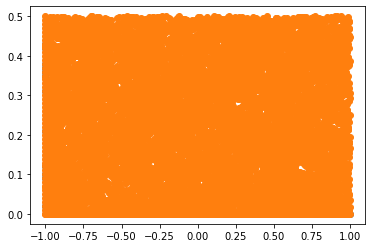

In [7]:
plt.scatter(X_u_train[:, 0], X_u_train[:, 1])
plt.scatter(X_f_train[:, 0], X_f_train[:, 1])
plt.show()

In [15]:
model = get_model(2, 3)
domain_t, domain_x = sample_domain(n=12, t_range=[0, 0.5])
domain_preds = model(torch.stack((domain_t, domain_x), dim=1))

In [55]:
errors = []
for i, nu in enumerate([0.01, 0.02, 0.03]):
    u_t = grad(outputs=domain_preds[:, i], inputs=domain_t, grad_outputs=torch.ones_like(domain_preds[:, i]), create_graph=True, retain_graph=True)[0]
    u_x = grad(outputs=domain_preds[:, i], inputs=domain_x, grad_outputs=torch.ones_like(domain_preds[:, i]), create_graph=True, retain_graph=True)[0]
    u_xx = grad(outputs=u_x, inputs=domain_x, grad_outputs=torch.ones_like(u_x), create_graph=True, retain_graph=True)[0]

    errors.append(u_t + domain_preds[:, i].squeeze() * u_x - (nu / np.pi) * u_xx)
    # print(u_t.shape, u_x.shape, u_xx.shape, domain_preds.shape)
print(torch.vstack(errors).shape)

In [58]:
loss = torch.nn.MSELoss()
loss(torch.vstack(errors), torch.zeros_like(torch.vstack(errors)))

tensor(0.0087, grad_fn=<MseLossBackward0>)

In [43]:
for i in range(domain_preds.shape[1]):
    x = grad(outputs=domain_preds[:, i], inputs=domain_t, grad_outputs=torch.ones_like(domain_preds[:, i]), create_graph=True, retain_graph=True)[0]
    print(x)

tensor([ 0.0324,  0.0202,  0.0300,  0.0267,  0.0305, -0.0039,  0.0288,  0.0161,
         0.0058,  0.0328,  0.0077,  0.0264], grad_fn=<SelectBackward0>)
tensor([-0.0993, -0.1037, -0.0997, -0.0971, -0.0998, -0.1095, -0.0986, -0.1054,
        -0.1040, -0.0973, -0.1099, -0.0843], grad_fn=<SelectBackward0>)
tensor([-0.0206, -0.0092, -0.0145, -0.0357, -0.0260,  0.0066, -0.0316, -0.0072,
         0.0045, -0.0120, -0.0057, -0.0463], grad_fn=<SelectBackward0>)


In [19]:
torch.ones_like(domain_preds).shape

torch.Size([12, 3])

In [ ]:
u_t + domain_preds.squeeze() * u_x - (0.01 / np.pi) * u_xx 

In [60]:
boundary_pts, boundary_y = sample_dirichlet_boundary()

In [66]:
print(boundary_y.shape)
boundary_y.expand(-1, 3)

torch.Size([100, 1])


tensor([[ 0.2064,  0.2064,  0.2064],
        [ 0.7114,  0.7114,  0.7114],
        [-0.7336, -0.7336, -0.7336],
        [-0.9845, -0.9845, -0.9845],
        [-0.9076, -0.9076, -0.9076],
        [ 0.9165,  0.9165,  0.9165],
        [-0.9301, -0.9301, -0.9301],
        [-0.7751, -0.7751, -0.7751],
        [ 0.4532,  0.4532,  0.4532],
        [ 0.7284,  0.7284,  0.7284],
        [ 0.7241,  0.7241,  0.7241],
        [-0.3719, -0.3719, -0.3719],
        [-0.9277, -0.9277, -0.9277],
        [ 0.3388,  0.3388,  0.3388],
        [ 0.5449,  0.5449,  0.5449],
        [ 0.5459,  0.5459,  0.5459],
        [ 0.8728,  0.8728,  0.8728],
        [ 0.9395,  0.9395,  0.9395],
        [ 0.6916,  0.6916,  0.6916],
        [-0.9991, -0.9991, -0.9991],
        [ 0.8383,  0.8383,  0.8383],
        [-0.8647, -0.8647, -0.8647],
        [-0.9704, -0.9704, -0.9704],
        [-0.6760, -0.6760, -0.6760],
        [-0.8419, -0.8419, -0.8419],
        [-0.4351, -0.4351, -0.4351],
        [ 0.8044,  0.8044,  0.8044],
 

In [76]:
model(boundary_pts).squeeze().reshape([10, 10, 3]).shape

torch.Size([10, 10, 3])

In [86]:
for param in model.parameters(): 
    print(param.shape)

torch.Size([100, 2])
torch.Size([100])
torch.Size([100, 100])
torch.Size([100])
torch.Size([100, 100])
torch.Size([100])
torch.Size([100, 100])
torch.Size([100])
torch.Size([100, 100])
torch.Size([100])
torch.Size([3, 100])
torch.Size([3])


In [104]:
print(len(list(model.parameters())))
for i, param in enumerate(model.parameters()): 
    print(param.shape)
    print(i)

12
torch.Size([100, 2])
0
torch.Size([100])
1
torch.Size([100, 100])
2
torch.Size([100])
3
torch.Size([100, 100])
4
torch.Size([100])
5
torch.Size([100, 100])
6
torch.Size([100])
7
torch.Size([100, 100])
8
torch.Size([100])
9
torch.Size([3, 100])
10
torch.Size([3])
11


In [98]:
val_t = torch.linspace(0, 1, 100)
val_x = torch.linspace(-1, 1, 200)
val_tx = torch.cartesian_prod(val_t, val_x)
with torch.no_grad(): 
    val_u = model(val_tx).squeeze().cpu().numpy()
val_u.shape

(20000, 3)

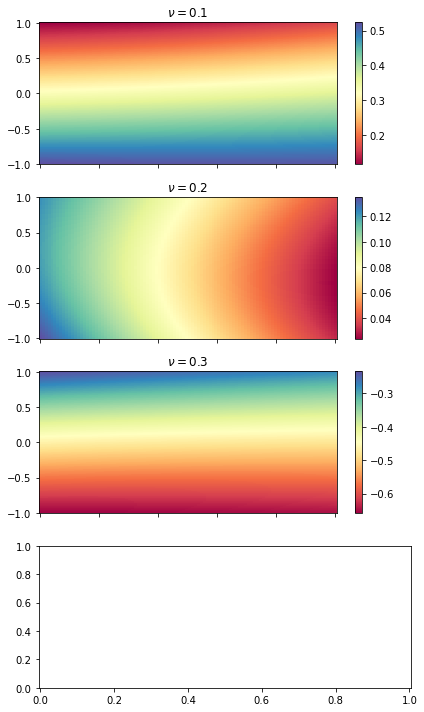

In [102]:
fig, axes = plt.subplots(4, 1, figsize=[6, 10], sharex=True)
for i, (visc, ax) in enumerate(zip([0.1, 0.2, 0.3], axes.flatten())): 
    im = ax.pcolormesh(val_t, val_x, val_u[:, i].reshape(len(val_t), len(val_x)).T, shading="nearest", cmap="Spectral")
    fig.colorbar(im, ax=ax)
    ax.set_title(f"$\\nu = {visc}$")
plt.tight_layout()
plt.show()

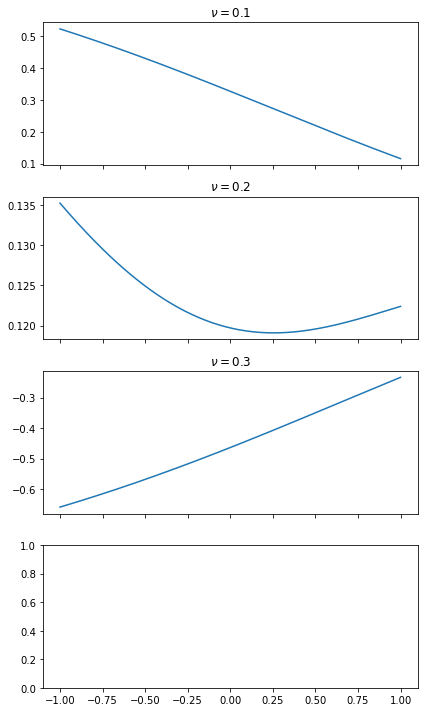

In [103]:
fig, axes = plt.subplots(4, 1, figsize=[6, 10], sharex=True)
for i, (visc, ax) in enumerate(zip([0.1, 0.2, 0.3], axes.flatten())): 
    ax.plot(val_x, val_u[:len(val_x), i])
    ax.set_title(f"$\\nu = {visc}$")
plt.tight_layout()
plt.show()

In [110]:
x = torch.rand([4, 3])
x

tensor([[0.3409, 0.8995, 0.7459],
        [0.8228, 0.2985, 0.3470],
        [0.2531, 0.4761, 0.4994],
        [0.3635, 0.0847, 0.5129]])

In [112]:
x[:, [0]]

tensor([[0.3409],
        [0.8228],
        [0.2531],
        [0.3635]])